In [163]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import os 
import networkx as nx
import igraph as ig
from ts2vg import NaturalVG
from scipy.spatial.distance import euclidean
from networkx import to_numpy_array
import pandas as pd
import csv

(30000, 10)
(30001, 10)
(30001, 10)
(30000, 10)
(30000, 10)
(30000, 10)
(30000, 4)
(30001, 4)
(30000, 4)
(30000, 4)
(30000, 4)
(30000, 4)


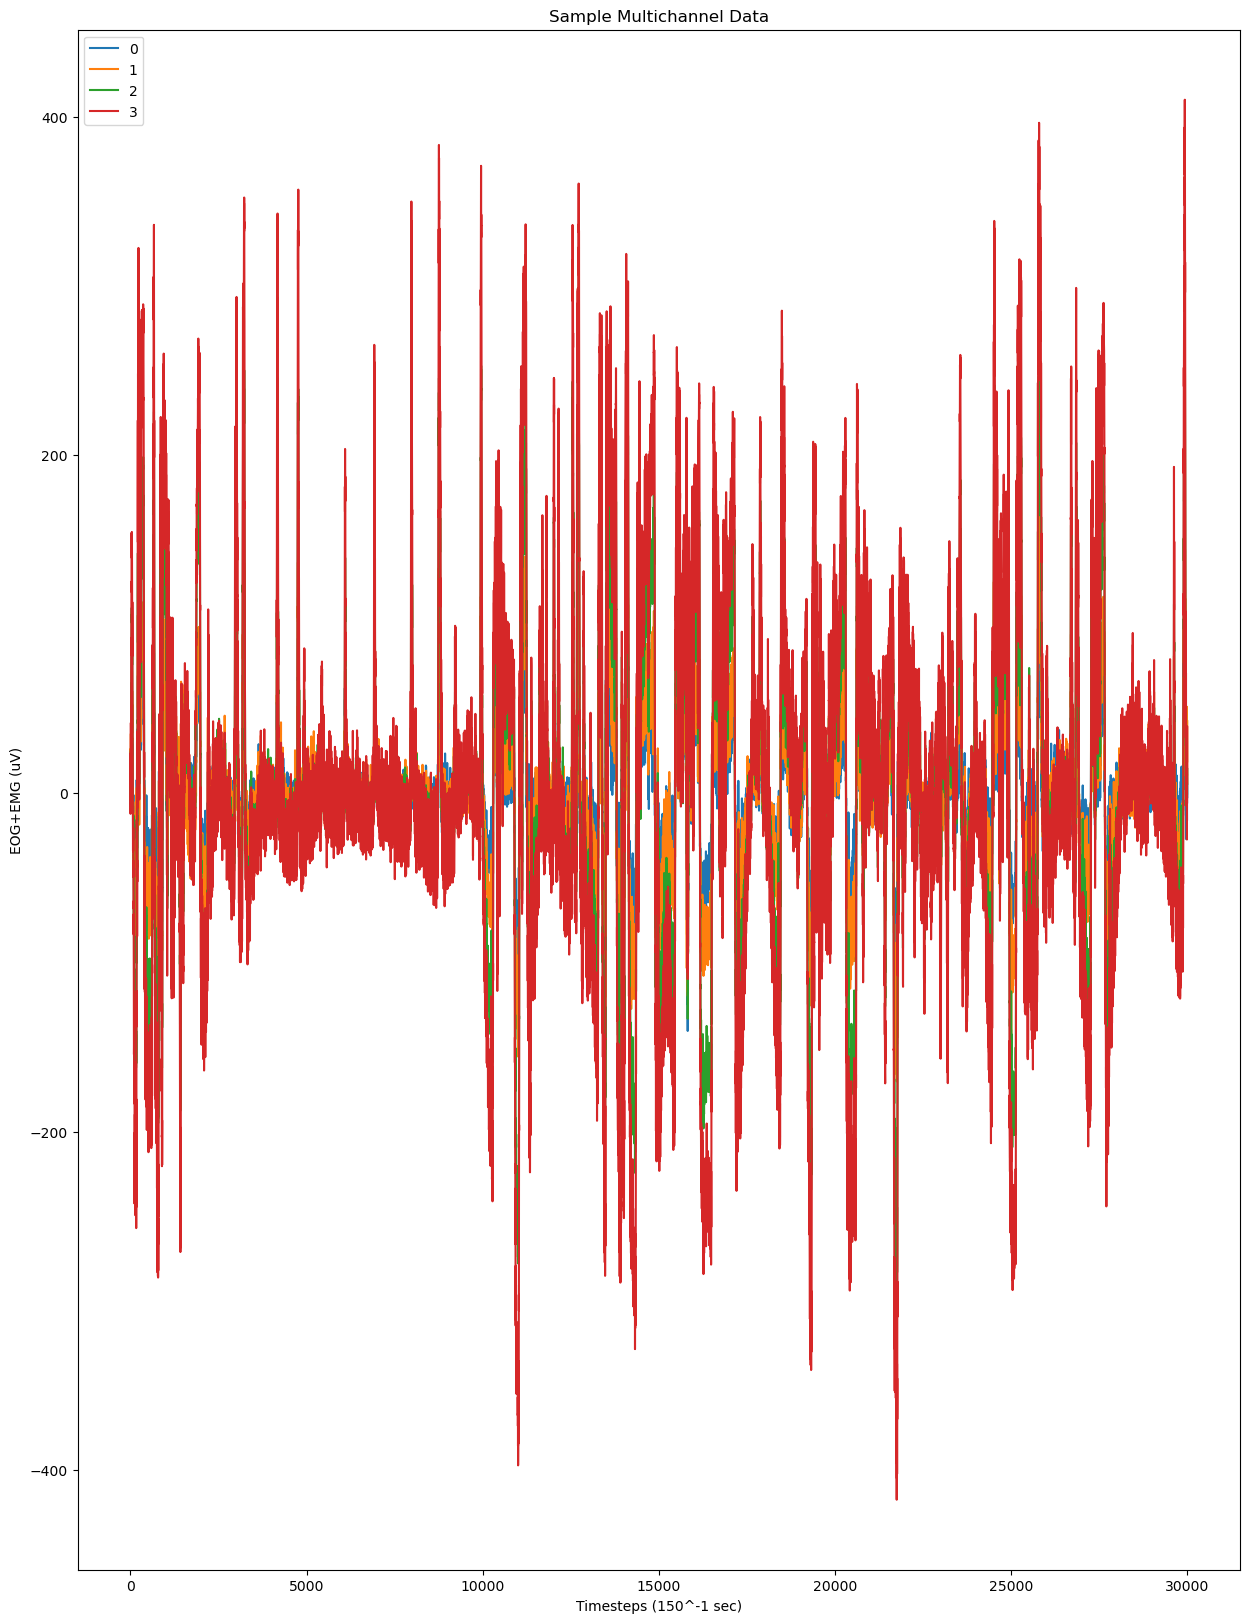

In [164]:

multichannel_timeseries = []
datadir = "../Multichannel Normalized/"
for each in os.listdir(datadir):
    print(scipy.io.loadmat(datadir+each)["X"].shape)
    lists = list(map(list, zip(*scipy.io.loadmat(datadir+each)["X"])))
    multichannel_timeseries.append([*lists])

multichannel_timeseries[0] = multichannel_timeseries[7]

fig, ax = plt.subplots()
i = 0
for each in multichannel_timeseries[0]:
    ax.plot(each, label=i)
    i+=1

ax.legend()
ax.set_xlabel('Timesteps (150^-1 sec)')
ax.set_ylabel('EOG+EMG (uV)')
ax.set_title('Sample Multichannel Data')
plt.rcParams["figure.figsize"] = [15, 3.50]
plt.show()



In [165]:
# data input
# multichannel_timeseries = []
# datadir = "../Multichannel\patient\\"
# for each in os.listdir(datadir):
#     temp = []
#     df = pd.read_csv(datadir+each)
#     for col in range(df.shape[1]):
#         temp.append(df.iloc[:, col])
#     multichannel_timeseries.append(temp)


# creates a list of lists of lists of timeseries

# for each in range(len(multichannel_timeseries[0])):
#     multichannel_timeseries[0][each] = list(multichannel_timeseries[0][each][55000:])
#     print(len(multichannel_timeseries[0][each]))


# fig, ax = plt.subplots()
# i = 0
# for each in multichannel_timeseries[0]:
#     ax.plot(each, label=i)
#     i+=1

# ax.legend()
# ax.set_xlabel('Timesteps (150^-1 sec)')
# ax.set_ylabel('EOG+EMG (uV)')
# ax.set_title('Sample Multichannel Data')
# plt.rcParams["figure.figsize"] = [15, 3.50]
# plt.show()


In [166]:
# function declarations to convert time series into natural visibility graphes
# https://github.com/CarlosBergillos/ts2vg

def construct_visibilty_graph(ts):
    # builds natural visibility graph
    vg = NaturalVG()
    vg.build(ts)
    # converts to networkx graph format
    g = vg.as_networkx()
    return g

def get_degree_sequence(vg):
    # get [(node, degrees),...] from a vg
    # convert to dict
    # get values (the degrees)
    ds = list(dict(nx.degree(vg)).values())
    return ds

In [167]:
from scipy.spatial.distance import minkowski
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

# Compute the covariance between two vectors
def covariance(x, y):
    return np.cov(x, y)[0][1]

normalized_distance_matrices = []
TIMESTEP = 150
OVERLAP = 130
TS = multichannel_timeseries[0][1]
TRUNCATED = len(TS) % TIMESTEP
DIST_METRIC = "Mino"
ch = 0

for ts in multichannel_timeseries[0]:
    ch += 1
    # segment y_filtered into consecutive non-overlapping intervals
    segments = [ts[i:i+TIMESTEP] for i in range(0, len(ts)-TIMESTEP+1, TIMESTEP-OVERLAP)]

    # construct a visibility graph for each segment
    graphs = [construct_visibilty_graph(segment) for segment in segments]

    # compute feature vectors for each graph using degree centrality
    feature_vectors = [np.array(list(nx.degree_centrality(graph).values())) for graph in graphs]

    # define distance matrix D for each segment using Euclidean distance

    distance_matrices = []
    for i in range(len(feature_vectors)):
        D = np.zeros(len(feature_vectors))
        for j in range(len(feature_vectors)):
            # cos
            D[j] = cosine(feature_vectors[i], feature_vectors[j])

            # euc
            # D[j] = np.linalg.norm(feature_vectors[i]-feature_vectors[j])

            # City block (Manhattan) distance
            # D[j] = cityblock(feature_vectors[i], feature_vectors[j])

            # mino
            # p = 3
            # D[j] = minkowski(feature_vectors[i], feature_vectors[j], p)
            
            # spearman
            # correlation, _ = spearmanr(feature_vectors[i], feature_vectors[j])
            # # Convert correlation to distance: distance = 1 - correlation
            # D[j] = 1 - correlation

            # covariance
            # cov = covariance(feature_vectors[i], feature_vectors[j])
            # D[j] = 1 - (cov / (np.std(feature_vectors[i]) * np.std(feature_vectors[j])))
        distance_matrices.append(D)

    # compute global distance matrix by averaging distances across all segments
    global_distance_matrix = np.vstack(distance_matrices)

    # normalize global distance matrix between 0 and 1
    normalized_distance_matrix = 1 - (global_distance_matrix - np.min(global_distance_matrix)) / (np.max(global_distance_matrix) - np.min(global_distance_matrix))
    print(str(ch) + " " + str(np.array(normalized_distance_matrix).shape))
 
    normalized_distance_matrices.append(normalized_distance_matrix)

average_normalized_distance_matrix = np.mean(normalized_distance_matrices, axis=0)

# construct weighted graph C using normalized distance matrix as adjacency matrix
# threshold = 0.0  # set a threshold to remove weak edges
# C = nx.from_numpy_array(normalized_distance_matrix * (normalized_distance_matrix >= threshold))

C = nx.from_numpy_array(average_normalized_distance_matrix)

# Set edge weights to similarity values
for u, v, d in C.edges(data=True):
    d['weight'] = average_normalized_distance_matrix[u][v]
    
# Remove self-loops
C.remove_edges_from(nx.selfloop_edges(C))

weightedGraph = C

# Draw the weighted graph
# nx.draw(C)


# mino distance takes 30s
# cosine takes 1m, 46s

1 (1493, 1493)
2 (1493, 1493)
3 (1493, 1493)
4 (1493, 1493)


{0: 1, 1: 1, 2: 1, 3: 1, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 4, 11: 4, 12: 3, 13: 3, 14: 3, 15: 4, 16: 3, 17: 3, 18: 3, 19: 1, 20: 4, 21: 1, 22: 1, 23: 3, 24: 1, 25: 1, 26: 3, 27: 3, 28: 3, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 3, 37: 3, 38: 3, 39: 3, 40: 4, 41: 4, 42: 4, 43: 4, 44: 4, 45: 4, 46: 4, 47: 4, 48: 3, 49: 3, 50: 3, 51: 1, 52: 3, 53: 3, 54: 4, 55: 3, 56: 3, 57: 1, 58: 1, 59: 1, 60: 1, 61: 4, 62: 4, 63: 1, 64: 4, 65: 1, 66: 1, 67: 1, 68: 3, 69: 3, 70: 4, 71: 4, 72: 4, 73: 4, 74: 4, 75: 3, 76: 1, 77: 1, 78: 4, 79: 3, 80: 3, 81: 0, 82: 4, 83: 4, 84: 1, 85: 1, 86: 1, 87: 1, 88: 3, 89: 3, 90: 4, 91: 4, 92: 4, 93: 4, 94: 4, 95: 3, 96: 3, 97: 3, 98: 1, 99: 1, 100: 1, 101: 4, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 4, 113: 4, 114: 4, 115: 4, 116: 4, 117: 4, 118: 4, 119: 3, 120: 4, 121: 4, 122: 4, 123: 4, 124: 4, 125: 3, 126: 4, 127: 4, 128: 4, 129: 4, 130: 1, 131: 1, 132: 1, 133: 1, 134: 4, 135: 4, 136: 4, 137: 4, 138: 

C:\Users\ianja\AppData\Local\Temp\ipykernel_1076\3689184716.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


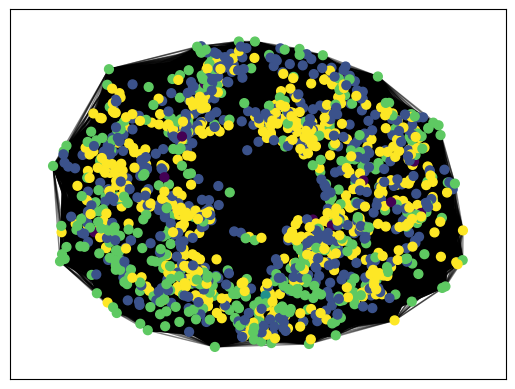

In [172]:
# community detection (clustering) of weighted graphes
# https://github.com/taynaud/python-louvain

# To achieve a modular visualization of the clusters detected by the discussed method and their
# mutual connections, we used a force-directed algorithm, namely the Frushterman–Reingold layout,
# as a graphical representation.
# Finally, for specific unsupervised FSS purposes, we considered a representative parameter for
# each cluster. Such parameters were identified based on their importance within the communities,
# by considering the signals with highest total degree centrality in their respective groups.

from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

RESOLUTION = (1.002)
partition = community_louvain.best_partition(weightedGraph, resolution=RESOLUTION)

print(partition)

plt.rcParams.update(plt.rcParamsDefault)
# draw the graph
pos = nx.spring_layout(weightedGraph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(weightedGraph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(weightedGraph, pos, alpha=0.5)
# plt.savefig("model.png", transparent=True)

plt.show()

# try averaging matrix across subjects, try concatenate signals end to end 

In [173]:
from collections import Counter

print("Generated partitions: " + str(set(list(partition.values()))))
par = str(len(set(list(partition.values()))))
# Create the dictionary
TSFAKE = [*range(len(TS))]
SEGMENTSFAKE = [TSFAKE[i:i+TIMESTEP] for i in range(0, len(TS)-TIMESTEP+1, TIMESTEP-OVERLAP)]

# Compute the majority_partition directly in the dictionary comprehension
# majority_partition = {i: Counter(partition[segment_num] for segment_num in [segmentNum for segmentNum, seg in enumerate(SEGMENTSFAKE) if i in seg]).most_common(1)[0][0] for i in range(len(TS) - TRUNCATED)}

majority_partition = {}
for i in range(len(TS) - TRUNCATED):
    # Build a list of segment numbers that include the current index
    relevant_segments = []
    for segmentNum, seg in enumerate(SEGMENTSFAKE):
        if i in seg:
            relevant_segments.append(segmentNum)
    
    # Count the occurrences of each partition in the relevant segments
    partition_counts = Counter(partition[segment_num] for segment_num in relevant_segments)
    
    # Find the most common partition, if there is one
    if len(partition_counts) > 0:
        most_common_partition = partition_counts.most_common(1)[0][0]
    else:
        most_common_partition = None
    
    # Add the most common partition to the dictionary
    majority_partition[i] = most_common_partition


print(majority_partition)


# explore method that generates 3 partition and 4 partition systems and uses the number of changes in partition over a range as a factor in deciding with partition to default to

Generated partitions: {0, 1, 2, 3, 4}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1,

30001


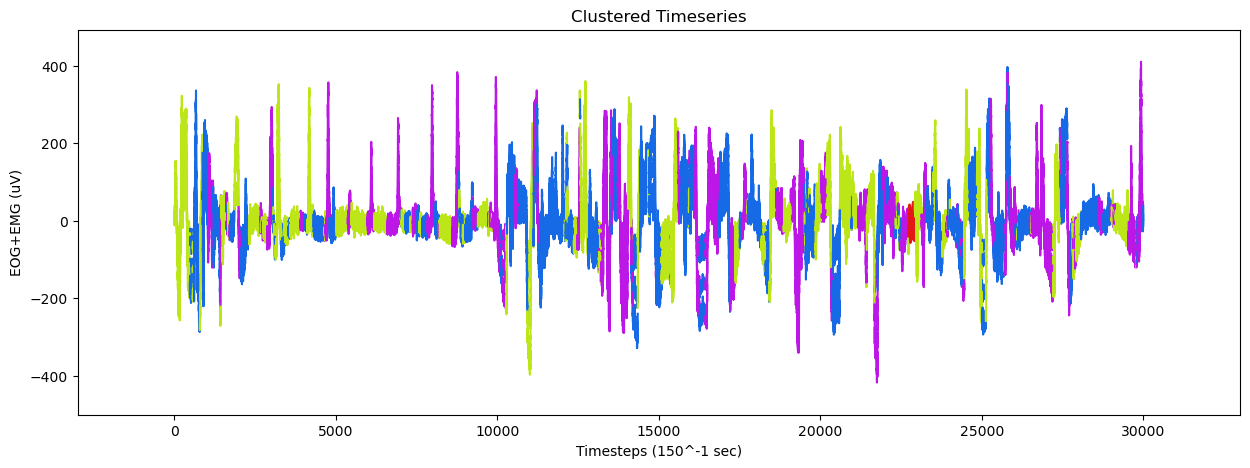

In [176]:
import colorsys
from matplotlib.collections import LineCollection


# In case I forgot to update it
DIST_METRIC = "Cosine"


n_colors = len(set(list(partition.values())))  # number of colors to generate
colors = {}
for i in range(n_colors): # generates highly contrasting colors by incrementing hue
    hue = i / float(n_colors)
    saturation = 0.9
    value = 0.9
    (r, g, b) = colorsys.hsv_to_rgb(hue, saturation, value)
    colors[i] = (r, g, b)

# Create a list of line segments and their colors
segments = []
colors_list = []

print(len(each))
for each in multichannel_timeseries[0]:
    i = 0
    while i < len(each) - TRUNCATED - 1:
        tempseg = []
        tempseg.append((i, each[i])) # (x, y)
        i+=1
        while i < len(each) - TRUNCATED - 1 and majority_partition[i] == majority_partition[i+1]:
            tempseg.append((i, each[i])) # (x, y)
            i+=1
        segments.append(tempseg)
        colors_list.append(colors[majority_partition[tempseg[0][0]]])

line_segments = LineCollection(segments, colors=colors_list)
plt.rcParams["figure.figsize"] = [15, 5]
fig, ax = plt.subplots()
ax.add_collection(line_segments)
ax.autoscale()
ax.margins(0.1)

plt.xlabel('Timesteps (150^-1 sec)')
plt.ylabel('EOG+EMG (uV)')
plt.title('Clustered Timeseries')

# Define the output directory
output_dir = 'Outputs'


# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Format the file name
file_name = f"{output_dir}/final_{DIST_METRIC}_ch_{len(multichannel_timeseries[0])}_len_{len(TS)}_ts_{TIMESTEP}_ovlp_{OVERLAP}_res_{RESOLUTION}_par_{par}.png"

# Use this file name in your savefig function
plt.savefig(file_name, format="png", dpi=600)

plt.show()



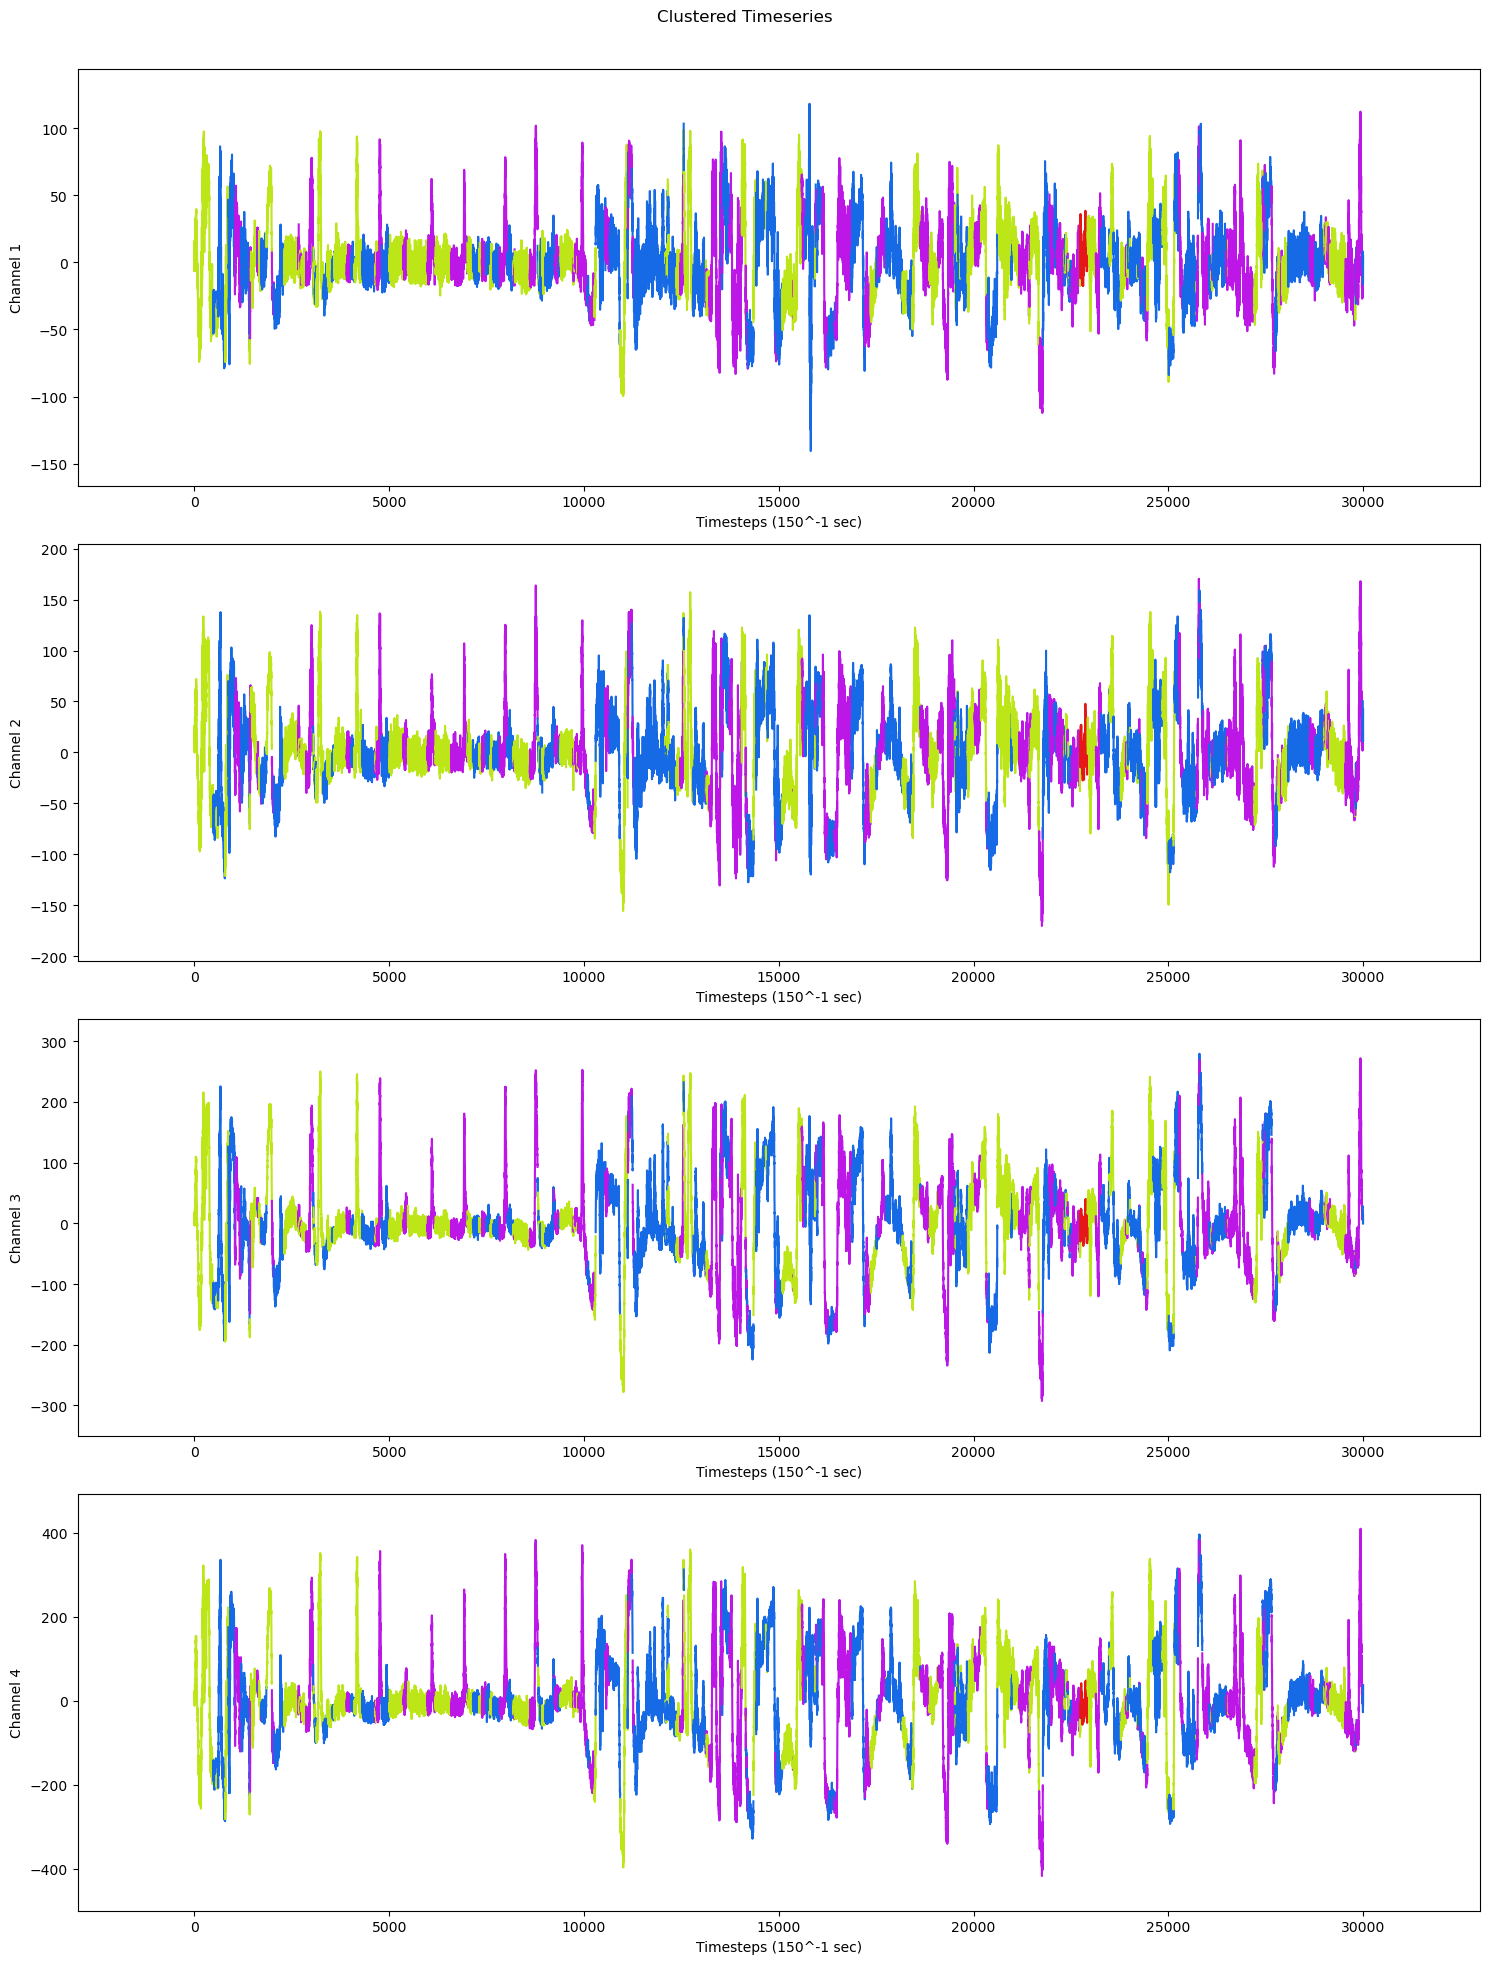

In [177]:
import os
import colorsys
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

n_colors = len(set(list(partition.values())))  # number of colors to generate
colors = {}
for i in range(n_colors):  # generates highly contrasting colors by incrementing hue
    hue = i / float(n_colors)
    saturation = 0.9
    value = 0.9
    (r, g, b) = colorsys.hsv_to_rgb(hue, saturation, value)
    colors[i] = (r, g, b)

# Define the number of rows for subplots
n_channels = len(multichannel_timeseries[0])
n_rows = n_channels

plt.rcParams["figure.figsize"] = [15, 5 * n_rows]  # Adjust height for the number of rows
fig, axs = plt.subplots(n_rows, 1)

for row, each in enumerate(multichannel_timeseries[0]):
    # Create a list of line segments and their colors
    segments = []
    colors_list = []

    i = 0
    while i < len(each) - TRUNCATED - 1:
        tempseg = []
        tempseg.append((i, each[i]))  # (x, y)
        i += 1
        while i < len(each) - TRUNCATED - 1 and majority_partition[i] == majority_partition[i + 1]:
            tempseg.append((i, each[i]))  # (x, y)
            i += 1
        segments.append(tempseg)
        colors_list.append(colors[majority_partition[tempseg[0][0]]])

    line_segments = LineCollection(segments, colors=colors_list)

    # Add each line collection to the respective subplot
    axs[row].add_collection(line_segments)
    axs[row].autoscale()
    axs[row].margins(0.1)

    # Set labels for each subplot
    axs[row].set_xlabel('Timesteps (150^-1 sec)')
    axs[row].set_ylabel('Channel ' + str(row+1))

# Set a common title for all subplots
fig.suptitle('Clustered Timeseries')

plt.tight_layout()  # Remove extra spaces around the subplots
plt.subplots_adjust(top=0.95)  # Adjust the space between the top of the subplots and the top of the figure

# Remove extra blank subplots
for i in range(n_channels, n_rows):
    fig.delaxes(axs[i])

# Define the output directory
output_dir = 'Outputs'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Format the file name
file_name = f"{output_dir}/final_seperated_{DIST_METRIC}_ch_{len(multichannel_timeseries[0])}_len_{len(TS)}_ts_{TIMESTEP}_ovlp_{OVERLAP}_res_{RESOLUTION}_par_{par}.png"

# Use this file name in your savefig function
plt.savefig(file_name, format="png", dpi=600)

plt.show()


use normalized signals 

use difference based signals 